# Analysis and clustring of my spotify favorite songs

For each track Spotify provides audio features. Here are there definitions taken directly from Spotify's developers documentation:
- acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- danceability - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- energy - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- instrumentalness - Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- key - The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- mode - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- tempo - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).





For my favorite songs (streamed more than 5 times) I gathered audio features provided by Spotify API, such as:

This notebook is continuation of XXX in which I covered:
1. Data gathering
2. Data preparation and exploratory analysis of my streaming history.
3. Spotify API: Adjsuting class written by XXXX. Adding extra methods for my case.

As a result from previous section I have got final data frame, which contains my songs streaming more than 5 times during last year with their audio features (dancability, lodness,..).

In this section I will focus on clustering. 
4. K-Means clustering. Finding accurate numer of clusters using elbow method.
5. Cluster visualisation using TSNE.

In [190]:
!pip install yellowbrick

     ------------------------------------ 282.6/282.6 KB 830.4 kB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\agata\OneDrive\Pulpit\Github\My_spotify_songs\spotify\Scripts\python.exe -m pip install --upgrade pip' command.


In [322]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import plotly as py
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

In [306]:
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('my_top_with_features.csv', index_col=0)

In [4]:
df.columns

Index(['index', 'endTime', 'artistName', 'trackName', 'msPlayed', 'counts',
       'trackID', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

In [5]:
df.head()

,index,endTime,artistName,trackName,msPlayed,counts,trackID,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,2020-06-30 10:13,Don Diablo,Bad,3349,20,1T4U8Q2DRfs6OUg8DEsRZf,0.791,0.738,0.0,...,0.1590,0.666,123.927,audio_features,1T4U8Q2DRfs6OUg8DEsRZf,spotify:track:1T4U8Q2DRfs6OUg8DEsRZf,https://api.spotify.com/v1/tracks/1T4U8Q2DRfs6...,https://api.spotify.com/v1/audio-analysis/1T4U...,169911.0,4.0
1,5,2020-06-30 10:41,Vicetone,Astronomia,194816,23,3hWfKBt3n7j1xqIy6LA5ve,0.653,0.945,5.0,...,0.4390,0.326,126.093,audio_features,3hWfKBt3n7j1xqIy6LA5ve,spotify:track:3hWfKBt3n7j1xqIy6LA5ve,https://api.spotify.com/v1/tracks/3hWfKBt3n7j1...,https://api.spotify.com/v1/audio-analysis/3hWf...,198095.0,4.0
2,6,2020-06-30 14:56,Xxanaxx,Nie znajdziesz mnie (feat. TEN TYP MES),231765,9,3MpP7wlzhZRFNL3OelqBdK,0.656,0.660,10.0,...,0.1080,0.551,127.047,audio_features,3MpP7wlzhZRFNL3OelqBdK,spotify:track:3MpP7wlzhZRFNL3OelqBdK,https://api.spotify.com/v1/tracks/3MpP7wlzhZRF...,https://api.spotify.com/v1/audio-analysis/3MpP...,234336.0,4.0
3,11,2020-07-01 17:48,MEDUZA,Lose Control,144362,50,7CHi4DtfK4heMlQaudCuHK,0.598,0.526,10.0,...,0.1400,0.529,123.935,audio_features,7CHi4DtfK4heMlQaudCuHK,spotify:track:7CHi4DtfK4heMlQaudCuHK,https://api.spotify.com/v1/tracks/7CHi4DtfK4he...,https://api.spotify.com/v1/audio-analysis/7CHi...,168387.0,4.0
4,13,2020-07-01 17:50,Ed Sheeran,Beautiful People (feat. Khalid),10112,9,4evmHXcjt3bTUHD1cvny97,0.640,0.648,5.0,...,0.0802,0.548,92.977,audio_features,4evmHXcjt3bTUHD1cvny97,spotify:track:4evmHXcjt3bTUHD1cvny97,https://api.spotify.com/v1/tracks/4evmHXcjt3bT...,https://api.spotify.com/v1/audio-analysis/4evm...,197867.0,4.0


In [6]:
df = df[['artistName', 'trackName', 'counts',
        'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

In [7]:
df.shape

(1119, 14)

In [8]:
df.isnull().sum()

artistName          0
trackName           0
counts              0
danceability        1
energy              1
key                 1
loudness            1
mode                1
speechiness         1
acousticness        1
instrumentalness    1
liveness            1
valence             1
tempo               1
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.describe()

,counts,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000
mean,15.694991,0.653943,0.768458,5.294275,-5.453666,0.548301,0.093434,0.108725,0.064336,0.209351,0.521856,122.172839
std,15.150483,0.143484,0.152823,3.647172,2.177823,0.497884,0.083398,0.163948,0.190084,0.179076,0.229088,22.548750
min,6.000000,0.108000,0.183000,0.000000,-16.011000,0.000000,0.023800,0.000007,0.000000,0.022200,0.036800,65.043000
25%,7.000000,0.575000,0.678000,2.000000,-6.567750,0.000000,0.040300,0.007790,0.000000,0.088225,0.341000,107.012250
50%,10.000000,0.670000,0.801500,5.000000,-5.199000,1.000000,0.059400,0.039800,0.000016,0.136000,0.529500,123.992000
75%,17.000000,0.751000,0.887000,8.000000,-3.997250,1.000000,0.109000,0.142500,0.002883,0.294000,0.709750,128.211750
max,124.000000,0.967000,0.997000,11.000000,1.479000,1.000000,0.490000,0.946000,0.982000,0.982000,0.979000,207.673000


In [11]:
df.dtypes

artistName           object
trackName            object
counts                int64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

In [50]:
(df.artistName.value_counts()).to_frame().reset_index()

,index,artistName
0,Muse,50
1,JAY-Z,27
2,Oliver Heldens,20
3,Coldplay,19
4,Post Malone,19
...,...,...
492,The Kooks,1
493,The Black Keys,1
494,Kings of Leon,1
495,Royal Blood,1


## Data Visualization
- all features if our songs are numeric
- mode and key, are encoded categorical variables

In [15]:
df.columns

Index(['artistName', 'trackName', 'counts', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')

In [16]:
num_cols = ['danceability', 'energy', 'key',
       'loudness','speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']
cat_cols = ['mode', 'key']

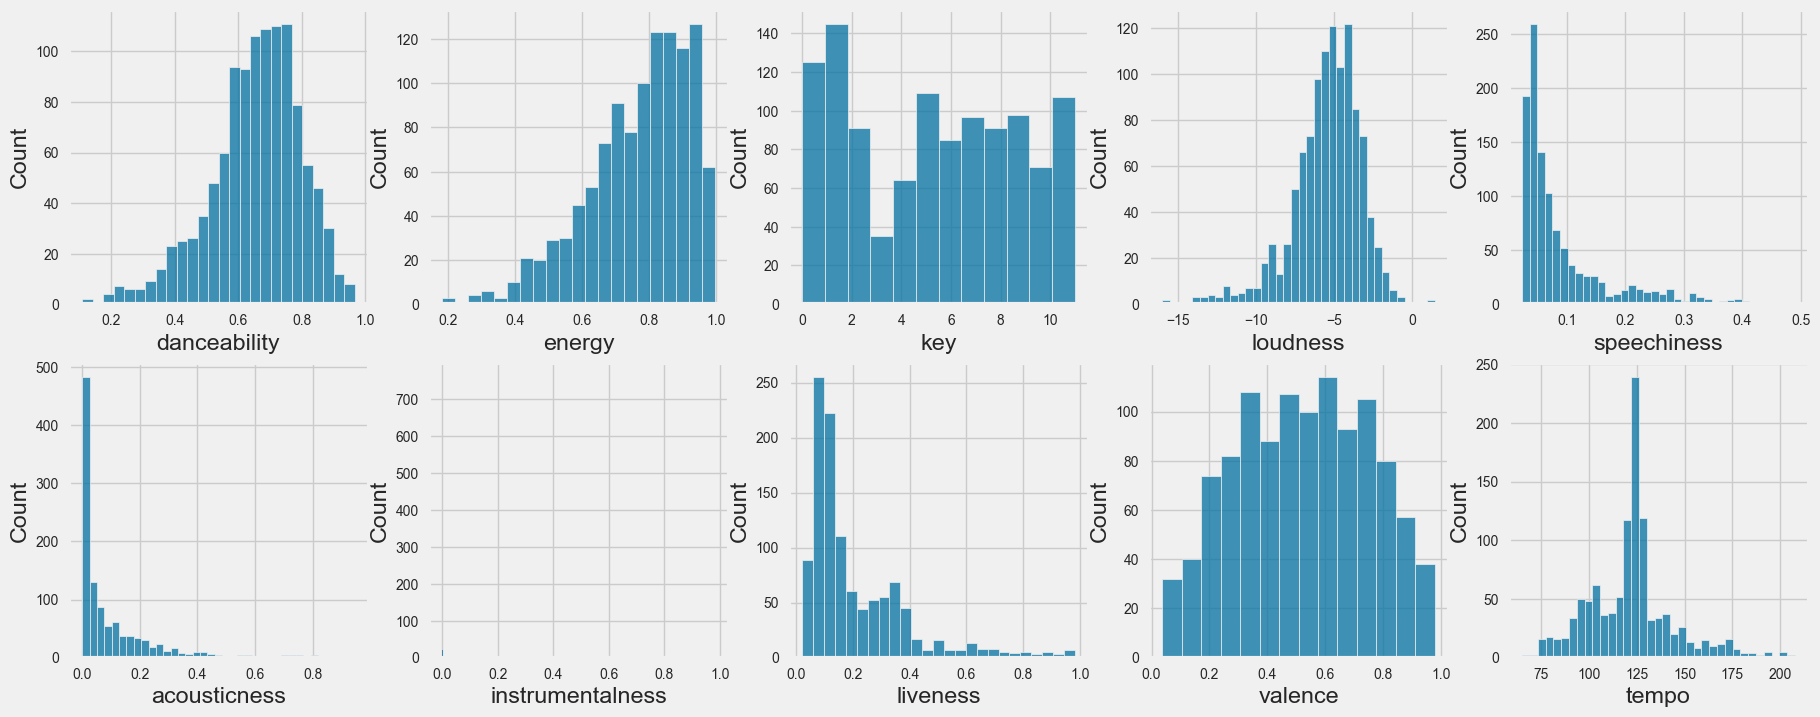

In [307]:
plt.figure(2 , figsize = (20 , 8))
n = 0
for i in num_cols:
    n += 1
    plt.subplot(2,5,n)
    sns.histplot(data=df, x=i)
plt.savefig('histograms.png')
plt.show()


- I'd rather like energetic electronic/rock/pop music, so the acousticness and speechiness of my songs is close to 0 and energy and danceability close to 1

- The mode in the tempo distribution is close to 126 BPM - most of EDM songs have such a tempo

- Instrumentalness has to be investigated more, since something looks strange, I'd expect it to be close to 0

In [36]:
df['instrumentalness'].describe()

count    1118.000000
mean        0.064336
std         0.190084
min         0.000000
25%         0.000000
50%         0.000016
75%         0.002883
max         0.982000
Name: instrumentalness, dtype: float64

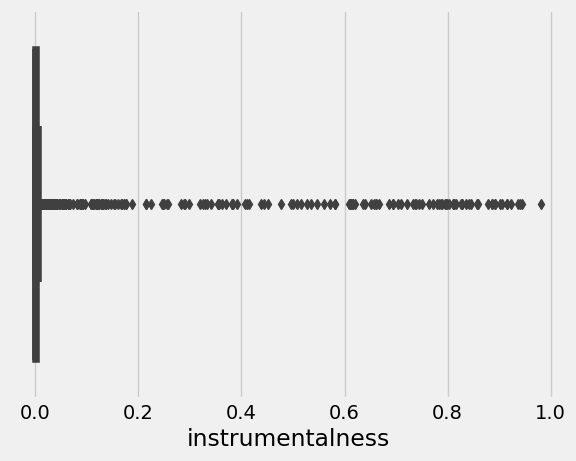

In [39]:
sns.boxplot(data = df, x ='instrumentalness')
plt.show()

In [43]:
df['instrumentalness'].quantile(0.90)

0.15330000000000008

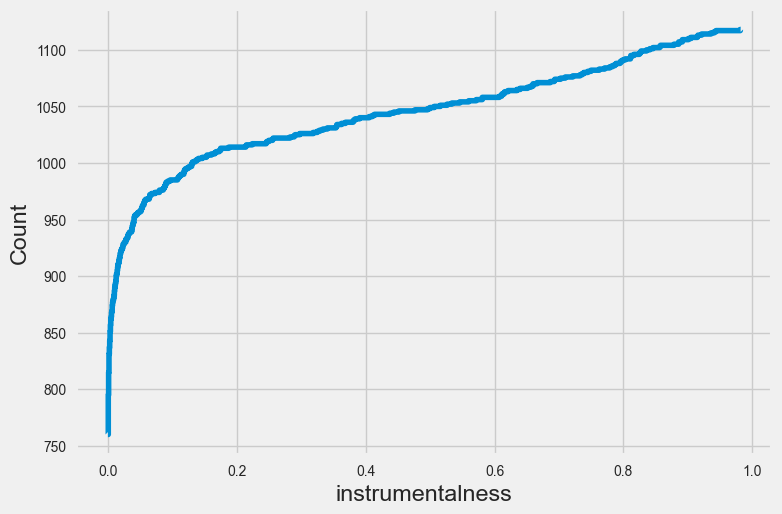

In [313]:
sns.histplot(data=df, x='instrumentalness', cumulative=True, element='step', fill=False)
plt.savefig('instrumentalness.png')

- As we can see, only 10 % of my songs have instrumentalness above 0.15, but 75% has it below 0.002883, so on the histogram we have high peak close to 0

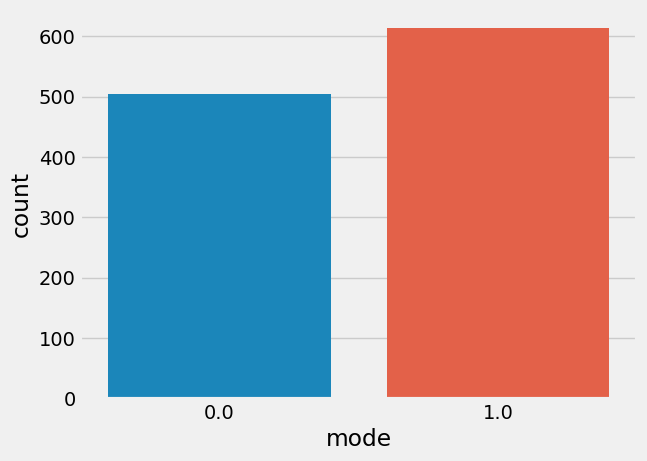

In [30]:
sns.countplot(data=df, x='mode')
plt.show()

In [314]:
# Old visualisatio

# for i in num_cols:
#     sns.histplot(data=df, x=i)
#     plt.show()

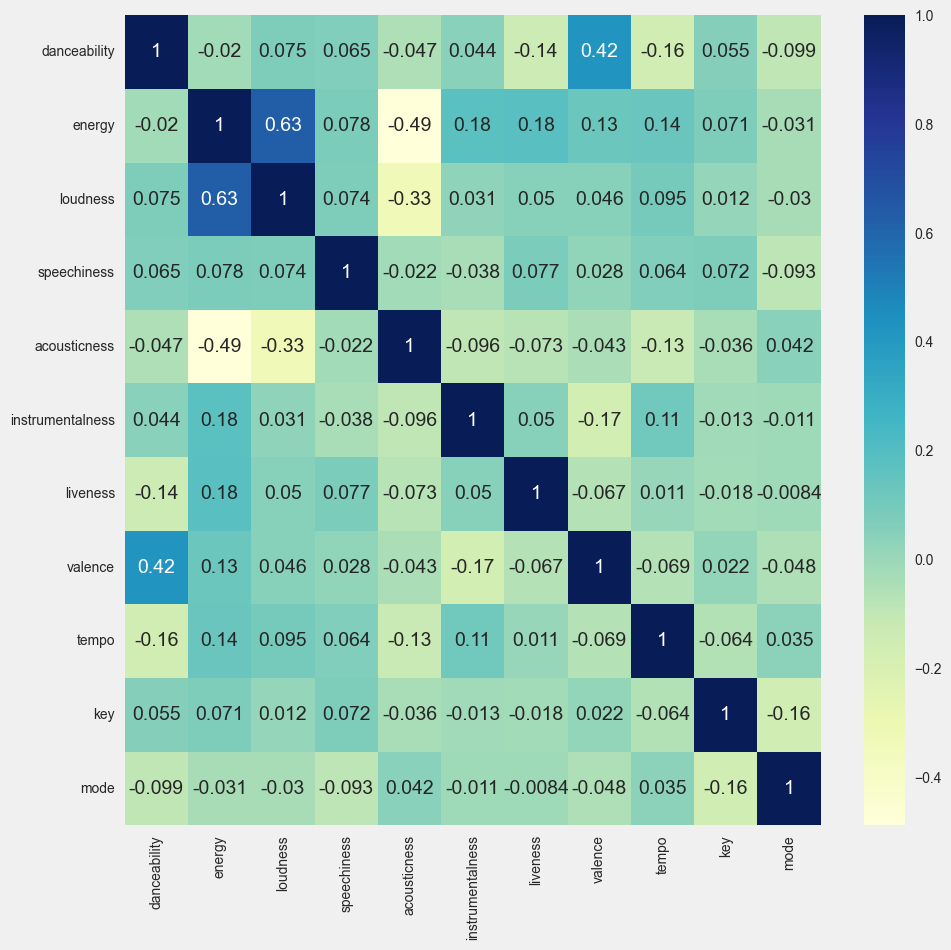

In [321]:
corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.savefig('correlations.jpg', bbox_inches='tight', pad_inches=0.4)
plt.show()

Summary:
- We can see positive correlation between loudness and energey, which makes sense and between danceability and valence (musical positiveness), so it's also correct so you always want to dance to positive sounds :)
- Acousticness is negativly correlated with most of the other features, escpecially with energy.

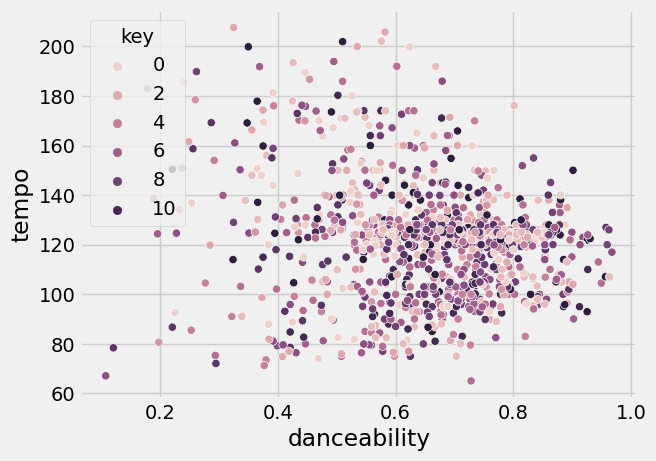

In [73]:
sns.scatterplot(data=df, x='danceability', y='tempo', hue='key')
plt.show()

# Clustering
1. Standarization
- There are different ranges (<0,1>, <-60,0>, ..) so as a first step we have to standarized our features
2. Dimensionality reduction - PCA
3. Visualisation - t-SNE
4. CLustering - KMeans, Agglomerative

In [177]:
X = df[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'key', 'mode']]

## Standarize features

In [227]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Dimensionality reduction
### PCA

In [86]:
pca = PCA(n_components=10)
pca.fit_transform(X_std)
pca.explained_variance_ratio_

array([0.19278168, 0.14480386, 0.10694165, 0.09561228, 0.09015226,
       0.08675555, 0.07623999, 0.07315288, 0.06084874, 0.04852196])

### t-SNE  2d

In [181]:
tsne = TSNE(n_components=2, perplexity=20)
data_2d = tsne.fit_transform(X_std)

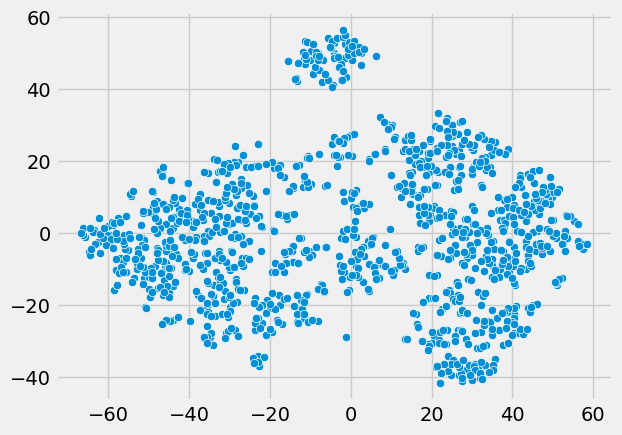

In [182]:
sns.scatterplot(data_2d[:,0], data_2d[:,1])
plt.show()

### t-SNE 3d

In [197]:
tsne_3 = TSNE(n_components=3, perplexity=20)
data_3d = tsne_3.fit_transform(X_std)

In [201]:
data_3d

array([[ 12.143719 ,  -2.3845382,   5.4458027],
       [ -3.770242 ,  13.907859 ,   5.0002694],
       [ -1.1257328,  -9.228589 ,  -5.7004795],
       ...,
       [-11.705465 ,  -7.0454664,   5.0331817],
       [ -9.69756  ,  11.6627035,   7.4715023],
       [ -6.705688 ,  16.675838 ,   6.300646 ]], dtype=float32)

In [210]:
# plotly Scatter 3d
trace1 = go.Scatter3d(
    x= data_3d[:,0],
    y= data_3d[:,1],
    z= data_3d[:,2],
    mode='markers',
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 't-SNE: A 3D projection of data in the reduced dimension',
#     scene = dict(
#             xaxis = dict(title  = 'Age'),
#             yaxis = dict(title  = 'Spending Score'),
#             zaxis = dict(title  = 'Annual Income')
#         )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Clustering
### KMeans
- determine the best number of cluster using elbow method and Sillhouette method

#### Elbow method

In [112]:
inertions = []
num_clusters = range(2, 12)

# Populating distortions for various clusters
for i in num_clusters:
    clt = KMeans(n_clusters=i, n_init=100)
    model = clt.fit(X_std)
    inertions.append(model.inertia_)

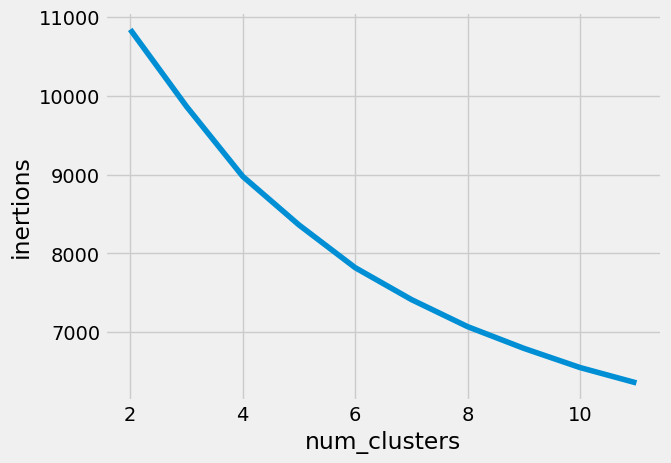

In [114]:
# Plotting elbow plot data
elbow_plot_data = pd.DataFrame({'num_clusters': num_clusters,
'inertions': inertions})
sns.lineplot(x='num_clusters', y='inertions',
data = elbow_plot_data)
plt.show()

- Elbow method visualisation using different library - yellowbricks

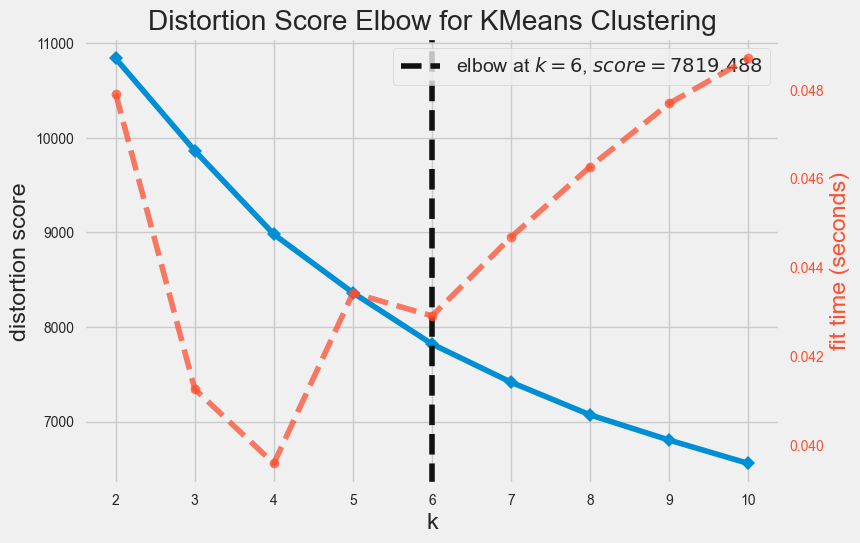

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [311]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(X_std)
plt.savefig('elbow_full.png', pad_inches=0.1)
Elbow_M.show()

#### Silhouette method

In [118]:
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters)
    # Fit and predict your k-Means object
    preds = kmeans.fit_predict(X)
    score = silhouette_score(X, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5010894773121933)
For n_clusters = 3, silhouette score is 0.582052287649519)
For n_clusters = 4, silhouette score is 0.5372727957458963)
For n_clusters = 5, silhouette score is 0.5069654789339285)
For n_clusters = 6, silhouette score is 0.4481061430923124)
For n_clusters = 7, silhouette score is 0.3913086178232002)
For n_clusters = 8, silhouette score is 0.3492124571767684)
For n_clusters = 9, silhouette score is 0.3619884151857513)


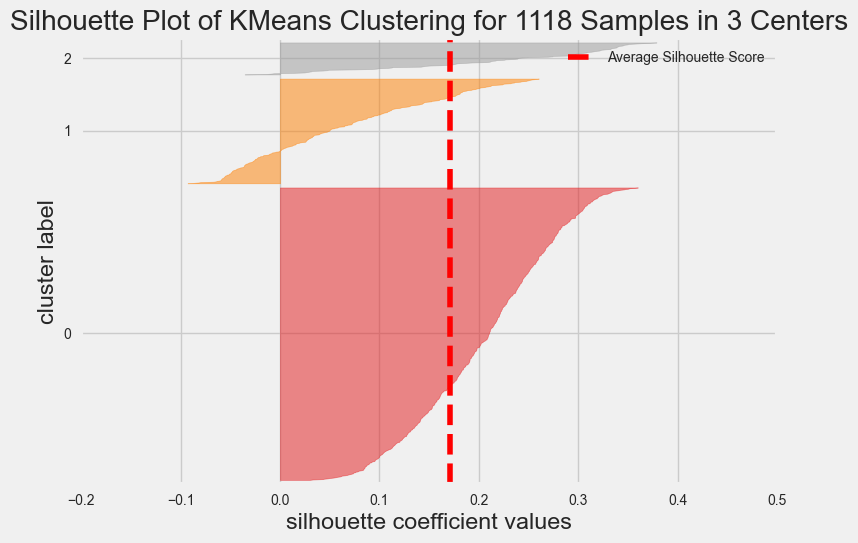

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1118 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [334]:
silhouette = SilhouetteVisualizer(KMeans(3))
silhouette.fit(X_std)
# plt.savefig('elbow_full.png', pad_inches=0.1)
silhouette.show()

- We cannot see exact elbow, but it seems like 6 cluster might be the right choice
- From Silhoutte method suggest 3 clusters

### Visualisation of 6 clusters

In [238]:
# Create k-mean object
clt = KMeans(n_clusters=6, n_init=100)
model = clt.fit(X_std)

labels = pd.Series(model.labels_)

In [239]:
df['labels_6'] = pd.Series(model.labels_)

In [240]:
colours = ['r', 'g', 'b', 'c', 'm', 'y']

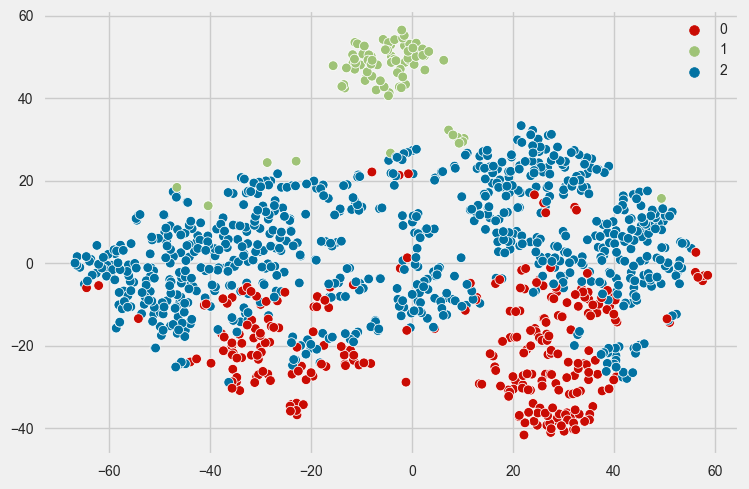

In [312]:
sns.scatterplot(data_2d[:,0], data_2d[:,1], hue=labels, palette=colours)
plt.savefig('tsne_6.png')
plt.show()

In [236]:
# plotly Scatter 3d
trace1 = go.Scatter3d(
    x= data_3d[:,0],
    y= data_3d[:,1],
    z= data_3d[:,2],
    mode='markers',
    marker=dict(
        color = df['labels'], 
        size= 20,
        line=dict(
            color= df['labels'],
            width= 12
        ),
        opacity=0.8
     )
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 't-SNE: A 3D projection of data in the reduced dimension',
#     scene = dict(
#             xaxis = dict(title  = 'Age'),
#             yaxis = dict(title  = 'Spending Score'),
#             zaxis = dict(title  = 'Annual Income')
#         )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Visualisation of 3 clusters

In [242]:
# Create k-mean object
clt = KMeans(n_clusters=3, n_init=100)
model = clt.fit(X_std)

labels = pd.Series(model.labels_)

In [243]:
df['labels_3'] = pd.Series(model.labels_)

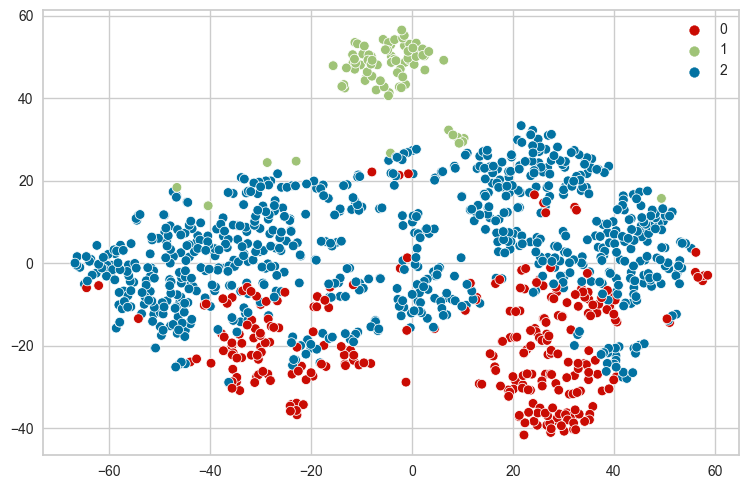

In [244]:
colours = ['r', 'g', 'b']
sns.scatterplot(data_2d[:,0], data_2d[:,1], hue=labels, palette=colours)
plt.show()

## Evaluating models
In unspervised clustering we do not have target feature and labels to easily score our model. Because so, we will perform EDA for both 3 and 6 clusters to determine which model is more accurate and what are profiles of our clusters.
## 3 Clusters

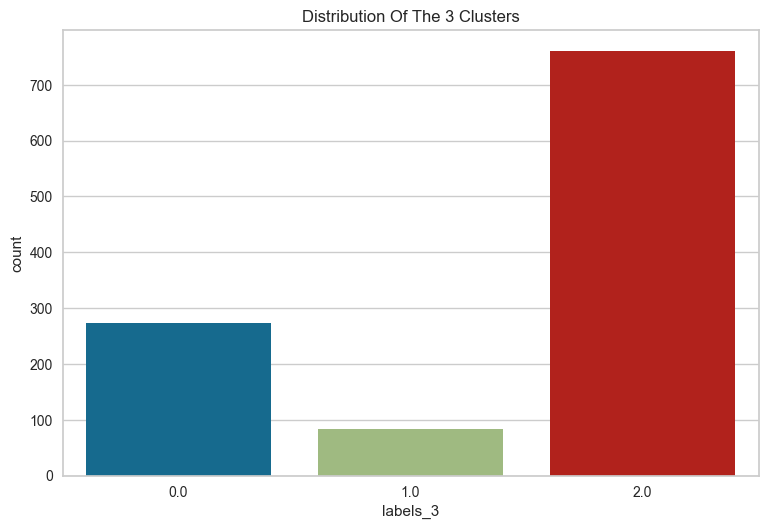

In [252]:
sns.countplot(x=df['labels_3'])
plt.title("Distribution Of The 3 Clusters")
plt.show()

As we can see clusters are not equaly distributes. Most of the songs are in cluster nr 2. Let's explore this a little bit more.

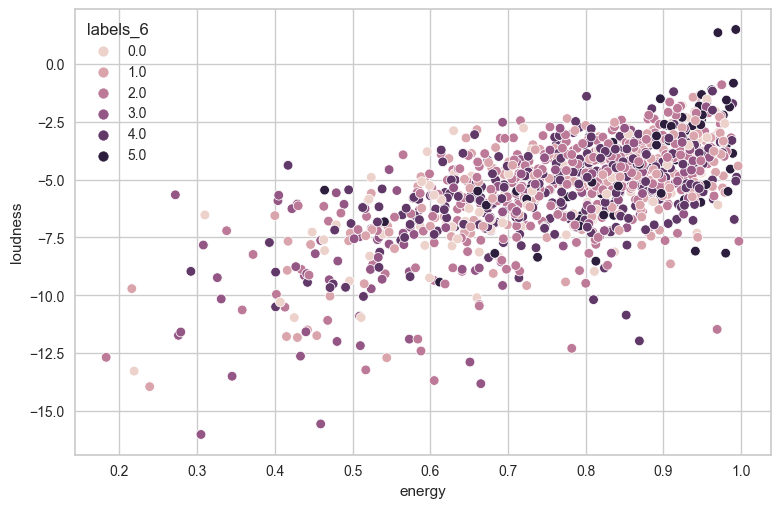

In [291]:
sns.scatterplot(data=df, x='energy', y='loudness', hue='labels_6')
plt.show()

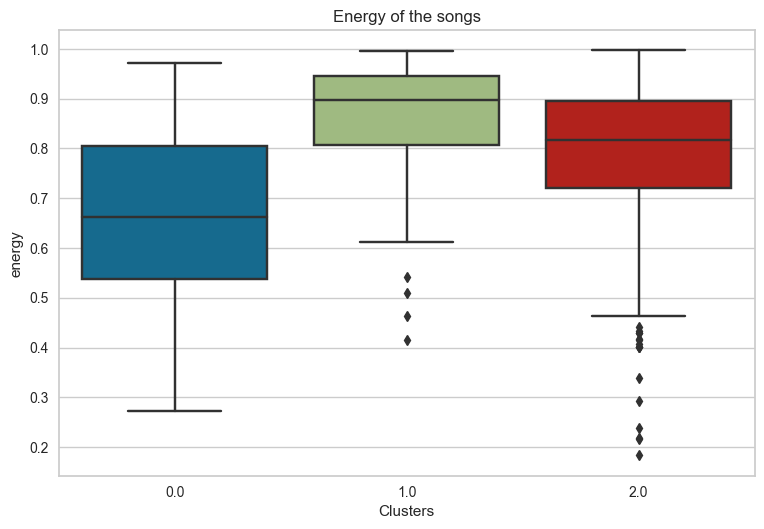

In [281]:
sns.boxplot(data=df, y='energy', x='labels_3')
plt.title('Energy of the songs')
plt.xlabel('Clusters')
plt.show()

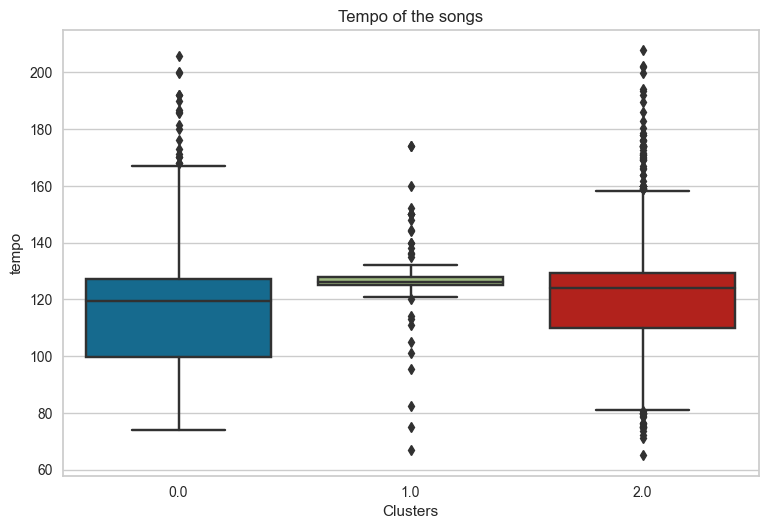

In [283]:
sns.boxplot(data=df, y='tempo', x='labels_3')
plt.title('Tempo of the songs')
plt.xlabel('Clusters')
plt.show()

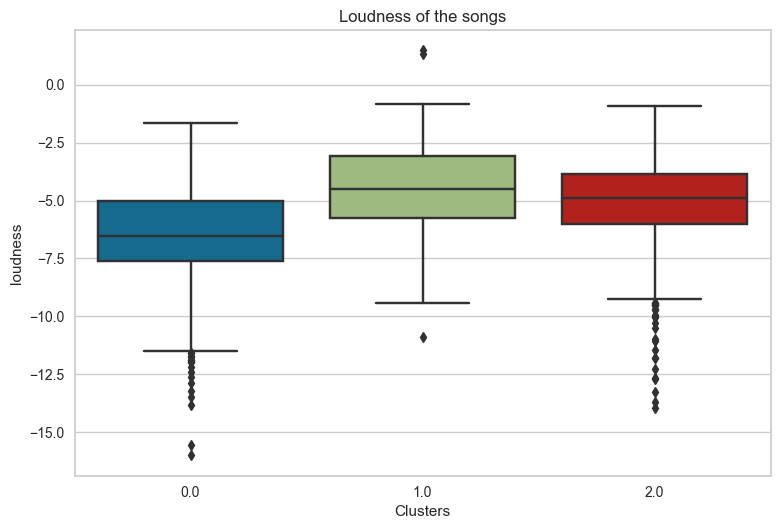

In [300]:
sns.boxplot(data=df, y='loudness', x='labels_3')
plt.title('Loudness of the songs')
plt.xlabel('Clusters')
plt.show()

- Cluster 1 seems to have to most energetic songs with tempo close to 126 BPM with really narrow IQR. I expect EDM songs here
- Cluster 0 has the lowest loudness, energy and tempo, so I expect slower songs here.
- Since distribution of those clusters are imbalanced and 70% of songs are in cluster 2, this cluster will be hard to define and it will contains all of the songs that are not close to cluster 1 and 2

Let's check what artists are in 1 and if it's EDM music stars.

In [302]:
df[df['labels_3'] == 1]['artistName'].value_counts()

Oliver Heldens       4
Dillon Francis       3
BROHUG               3
Tiësto               3
Tujamo               3
                    ..
Eric Prydz           1
Carnage              1
Mike Candys          1
David Guetta         1
Reinier Zonneveld    1
Name: artistName, Length: 65, dtype: int64

In [303]:
df[df['labels_3'] == 0]['artistName'].value_counts()

Muse                 15
Childish Gambino     12
JAY-Z                 9
U2                    9
Justin Timberlake     7
                     ..
Miguel                1
Kid Ink               1
Chris Brown           1
Dennis Lloyd          1
Daria Zawiałow        1
Name: artistName, Length: 175, dtype: int64

In [304]:
df[df['labels_3'] == 2]['artistName'].value_counts()

Muse                 34
JAY-Z                18
Oliver Heldens       15
Post Malone          13
Coldplay             13
                     ..
The Black Keys        1
Lil Nas X             1
Cat Dealers           1
Mr. Probz             1
Reinier Zonneveld     1
Name: artistName, Length: 381, dtype: int64

## 6 Clusters

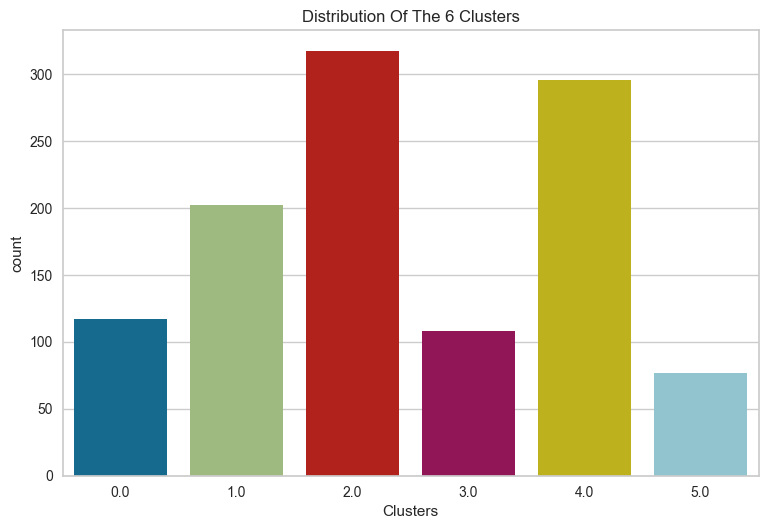

In [290]:
sns.countplot(x=df['labels_6'])
plt.title("Distribution Of The 6 Clusters")
plt.xlabel('Clusters')
plt.show()

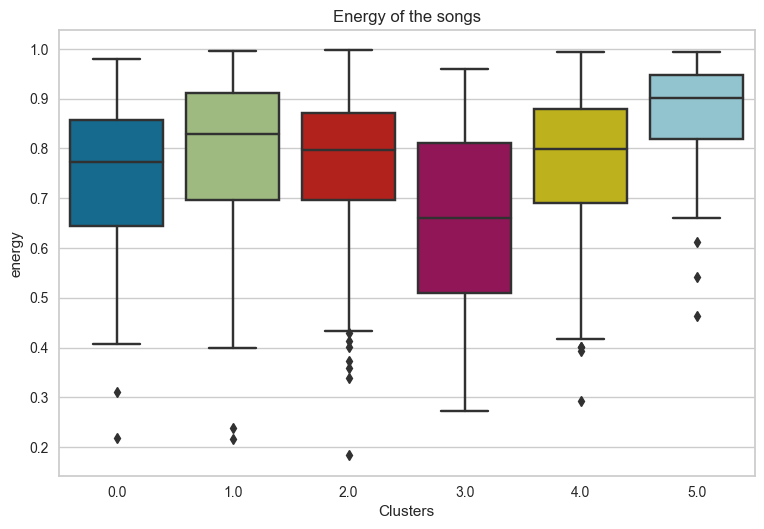

In [292]:
sns.boxplot(data=df, y='energy', x='labels_6')
plt.title('Energy of the songs')
plt.xlabel('Clusters')
plt.show()

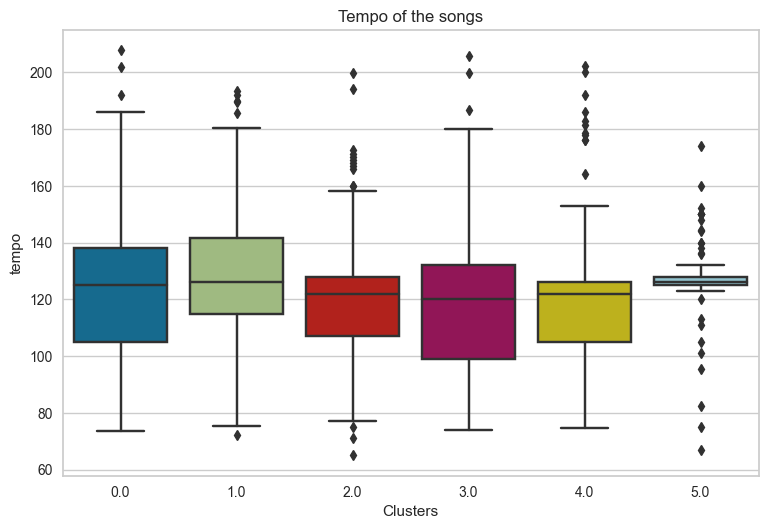

In [294]:
sns.boxplot(data=df, y='tempo', x='labels_6')
plt.title('Tempo of the songs')
plt.xlabel('Clusters')
plt.show()

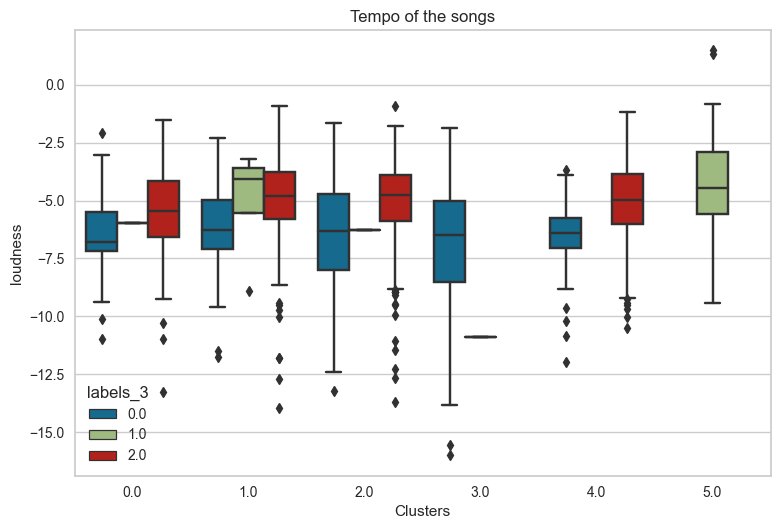

In [297]:
sns.boxplot(data=df, y='loudness', x='labels_6', hue='labels_3')
plt.title('Tempo of the songs')
plt.xlabel('Clusters')
plt.show()

In [245]:
df.columns

Index(['artistName', 'trackName', 'counts', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'labels', 'labels_6', 'labels_3'],
      dtype='object')

In [ ]:
sns.scatterplot(data=df, x='danceability', y='tempo', hue='key')
plt.show()

In [54]:
X = df[['danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
        'tempo']]

In [55]:
# Standarize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [62]:
# Create k-mean object
clt = KMeans(n_clusters=7, n_init=100)

# Train model
model = clt.fit(X_std)

In [63]:
labels = pd.Series(model.labels_)

In [64]:
labels.unique()

array([4, 3, 6, 0, 1, 2, 5])

In [65]:
df['labels'] = pd.Series(model.labels_)

In [56]:
inertions = []
num_clusters = range(2, 12)

# Populating distortions for various clusters
for i in num_clusters:
    clt = KMeans(n_clusters=i, n_init=100)
    model = clt.fit(X_std)
    inertions.append(model.inertia_)

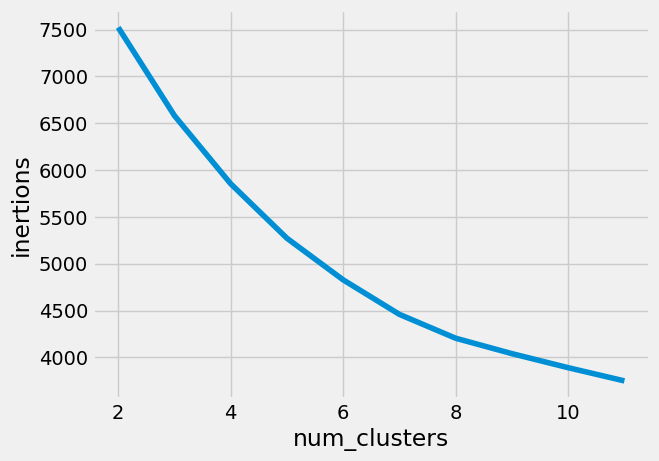

In [57]:
# Plotting elbow plot data
elbow_plot_data = pd.DataFrame({'num_clusters': num_clusters,
'inertions': inertions})
sns.lineplot(x='num_clusters', y='inertions',
data = elbow_plot_data)
plt.show()

In [66]:
tsne = TSNE(n_components=2, perplexity=20)

In [67]:
data_2d = tsne.fit_transform(X_std)

C:\Users\agata\OneDrive\Pulpit\Github\My_spotify_songs\spotify\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\agata\OneDrive\Pulpit\Github\My_spotify_songs\spotify\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [68]:
# colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']
colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

C:\Users\agata\OneDrive\Pulpit\Github\My_spotify_songs\spotify\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


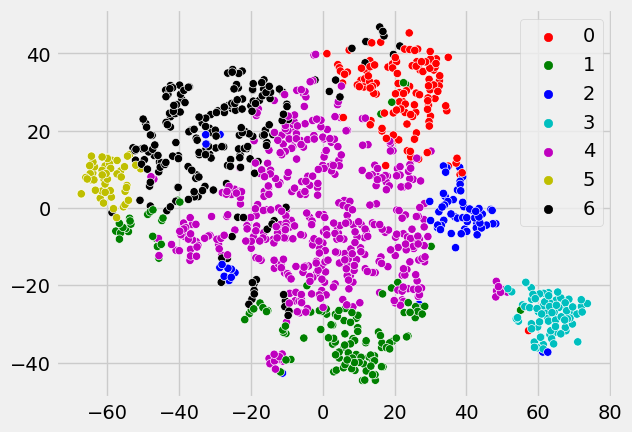

In [69]:
sns.scatterplot(data_2d[:,0], data_2d[:,1], hue=labels, palette=colours)
plt.show()